In [1]:
import os
from pathlib import Path

path_cwd = '/nvme/wangding/Desktop/tsim/tsim'
os.chdir(Path(path_cwd).absolute())
os.getcwd()

'/nvme/wangding/Desktop/tsim/tsim'

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from pathlib import Path
from graph.load import load_graph
from eval import *
from graph.process import generate_unique_node_id
import pandas as pd
import os
#import cv2
import pickle
import torch
from matplotlib.pyplot import figure
import math
import numpy as np
plt.style.use('default')
from sklearn.preprocessing import MinMaxScaler
import re
import numpy as np

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import re

import glob
import pickle
from collections import defaultdict

In [7]:
exp_dir = Path(path_cwd).resolve().parent / "experiment"
exp_dir

PosixPath('/nvme/wangding/Desktop/tsim/experiment')

In [8]:
training_step = 400
pred_step = 5
prev_step = 20
case =  "traci_tls"
test = "test2"
out = "out_dim_50_n_heads_4_n_layer_4_pred_step_5"

sim_feat = load_data(exp_dir,case,test,out,training_step,pred_step)

In [9]:
real_data_dir = exp_dir / case / "data" / test / "test_data"
train_data_dir = exp_dir / case  / "data" / test / "train_data"
node_all = pd.read_csv(train_data_dir / "node_all.csv")
node_id_dict = generate_unique_node_id(node_all)

real_struc, real_feat, node_id_dict, scalers =  load_graph(real_data_dir,0,training_step+pred_step*10,node_id_dict)

In [10]:
sim_feat = unscale_feat(sim_feat, scalers)
real_feat = unscale_feat(real_feat, scalers)

### 2. Car following behavior

In [11]:
def CF_plot(real_struc, real_feat_dict,sim_feat_dict,front_veh_id,behind_veh_id,feat_name,plot_cf):
    cf_struc = get_cf_df(real_struc)
    veh_pair = cf_struc[(cf_struc['front_veh'] == front_veh_id) & (cf_struc['behind_veh'] == behind_veh_id)]

    feat_front = get_feat_df(real_feat_dict, 'veh', front_veh_id, feat_name)
    feat_behind = get_feat_df(real_feat_dict, 'veh', behind_veh_id, feat_name)
    feat_front_sim = get_feat_df(sim_feat_dict, 'veh', front_veh_id, feat_name)
    feat_behind_sim = get_feat_df(sim_feat_dict, 'veh', behind_veh_id,feat_name)

    merge_front = pd.merge(veh_pair, feat_front, on='time')
    merge_behind = pd.merge(merge_front, feat_behind, on='time')
    merge_front_sim = pd.merge(veh_pair, feat_front_sim, on='time')
    merge_behind_sim = pd.merge(merge_front_sim, feat_behind_sim, on='time')
    
    if plot_cf == 1:
        plt.plot(merge_behind['time'], merge_behind[feat_name+str(front_veh_id)], label = "Front_car")
        plt.plot(merge_behind['time'], merge_behind[feat_name+str(behind_veh_id)], label = "Follower_car")
        plt.plot(merge_behind_sim['time'], merge_behind_sim[feat_name+str(front_veh_id)], linestyle='--',  marker='o', markersize=2, label = "Front_car_sim")
        plt.plot(merge_behind_sim['time'],merge_behind_sim[feat_name+str(behind_veh_id)], linestyle='--',  marker='o',
            markerfacecolor='blue', markersize=2, label = "Follower_car_sim")
        plt.xlabel("Time step")
        plt.ylabel(feat_name.capitalize())
        plt.title(feat_name.capitalize() + " of vehicle pairs")
        plt.legend(fontsize=10)
        plt.show()
    else:
        return merge_behind_sim

In [12]:
cf_struc = get_cf_df(real_struc)
df = cf_struc[['front_veh','behind_veh']].drop_duplicates()
all_veh_pairs = list(set([(i,j) for i in df['front_veh'] for j in df['behind_veh']]))

In [22]:
long_cf_pairs = []
for pair in all_veh_pairs:
    front_veh_id, behind_veh_id = pair
    veh_pair = cf_struc[(cf_struc['front_veh'] == front_veh_id) & (cf_struc['behind_veh'] == behind_veh_id)]
    pair_time = len(set(veh_pair.time))
    if pair_time>50: 
        # print(min(veh_pair['time']))
        if max(veh_pair['time'])>0:
            long_cf_pairs.append((front_veh_id, behind_veh_id, pair_time))

In [23]:
long_cf_pairs

[(41, 42, 126),
 (3, 5, 82),
 (73, 77, 53),
 (9, 11, 131),
 (29, 34, 77),
 (1, 3, 84),
 (54, 55, 109),
 (45, 48, 106),
 (57, 58, 100),
 (63, 64, 91),
 (28, 30, 103),
 (25, 29, 106),
 (23, 25, 124),
 (70, 71, 74),
 (58, 59, 96),
 (68, 69, 101),
 (20, 26, 104),
 (7, 8, 134),
 (65, 68, 106),
 (71, 74, 63),
 (10, 13, 106),
 (72, 73, 67),
 (13, 14, 102),
 (14, 15, 100),
 (49, 51, 97),
 (61, 63, 90),
 (30, 31, 98),
 (0, 2, 85),
 (27, 28, 106),
 (4, 6, 71),
 (62, 66, 107),
 (42, 45, 121),
 (40, 41, 128),
 (43, 44, 117),
 (46, 47, 108),
 (56, 57, 102),
 (59, 60, 91),
 (50, 53, 92),
 (33, 35, 82),
 (51, 52, 94),
 (11, 12, 125),
 (8, 9, 131),
 (64, 67, 88),
 (44, 46, 114),
 (18, 19, 110),
 (47, 49, 108),
 (15, 16, 89),
 (21, 22, 128),
 (12, 17, 92),
 (48, 50, 103),
 (22, 23, 128),
 (39, 43, 119),
 (31, 32, 92),
 (2, 4, 90),
 (26, 27, 110),
 (19, 24, 77),
 (37, 40, 131),
 (66, 70, 96),
 (32, 33, 91),
 (38, 39, 125)]

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

def CF_plot(real_struc, real_feat_dict, sim_feat_dict, front_veh_id, behind_veh_id, feat_name, plot_cf):
    cf_struc = get_cf_df(real_struc)
    veh_pair = cf_struc[(cf_struc['front_veh'] == front_veh_id) & (cf_struc['behind_veh'] == behind_veh_id)]

    feat_front = get_feat_df(real_feat_dict, 'veh', front_veh_id, feat_name)
    feat_behind = get_feat_df(real_feat_dict, 'veh', behind_veh_id, feat_name)
    feat_front_sim = get_feat_df(sim_feat_dict, 'veh', front_veh_id, feat_name)
    feat_behind_sim = get_feat_df(sim_feat_dict, 'veh', behind_veh_id, feat_name)

    merge_front = pd.merge(veh_pair, feat_front, on='time')
    merge_behind = pd.merge(merge_front, feat_behind, on='time')
    merge_front_sim = pd.merge(veh_pair, feat_front_sim, on='time')
    merge_behind_sim = pd.merge(merge_front_sim, feat_behind_sim, on='time')
    
    
    pre_res_front = merge_behind[feat_name+str(front_veh_id)][:prev_step]
    sim_res_front = merge_behind_sim[feat_name+str(front_veh_id)]
    
    pre_res_behind = merge_behind[feat_name+str(behind_veh_id)][:prev_step]
    sim_res_behind = merge_behind_sim[feat_name+str(behind_veh_id)]
    
    sim_res_behind = pd.concat([pre_res_behind, sim_res_behind])[:(max(merge_behind['time'])-min(merge_behind['time']))]
    sim_res_front = pd.concat([pre_res_front, sim_res_front])[:(max(merge_behind['time'])-min(merge_behind['time']))]
    
    sim_time = pd.concat([merge_behind['time'][:prev_step],merge_behind_sim['time']])[:(max(merge_behind['time'])-min(merge_behind['time']))]

    
    if plot_cf == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

        ax.plot(merge_behind['time'], merge_behind[feat_name+str(front_veh_id)], linewidth=2, color='red', label="Front car - SUMO")
        ax.plot(merge_behind['time'], merge_behind[feat_name+str(behind_veh_id)], linewidth=2, color='blue', label="Follower car - SUMO")
        ax.plot(sim_time, sim_res_front, linestyle='--', linewidth=2, marker='o', markersize=4, color='red', label="Front car - TransWorld")
        ax.plot(sim_time, sim_res_behind, linestyle='--', linewidth=2, marker='o', markersize=4, color='blue', label="Follower car - TransWorld")
        ax.axvline(x=training_step, linestyle='--', linewidth=1, color='gray')

        ax.set_xlabel("Time step", fontsize=14)
        ax.set_ylabel(feat_name.capitalize(), fontsize=14)
        #ax.set_title(f"{feat_name.capitalize()} of vehicle pairs ({front_veh_id} - {behind_veh_id})", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.legend(fontsize=12)

        #text_x = max(feat_real['time'])
        text_y = max(merge_behind[feat_name+str(front_veh_id)])
        # Add "Training" and "Evaluation" text
        ax.text(training_step-5, text_y, "Training", fontsize=12, ha="right")
        ax.text(training_step+5, text_y, "Evaluation", fontsize=12, ha="left")
        
        #text_x = max(merge_behind['time'])
        #text_y = min(merge_behind[feat_name+str(behind_veh_id)])
        #ax.text(1, 1, f"Node type: {'veh'}\nNode ID: {node_id}\nFeature name: {feat_name}\nTraining step: 0~{training_step}", fontsize=14, ha='right', va='bottom')


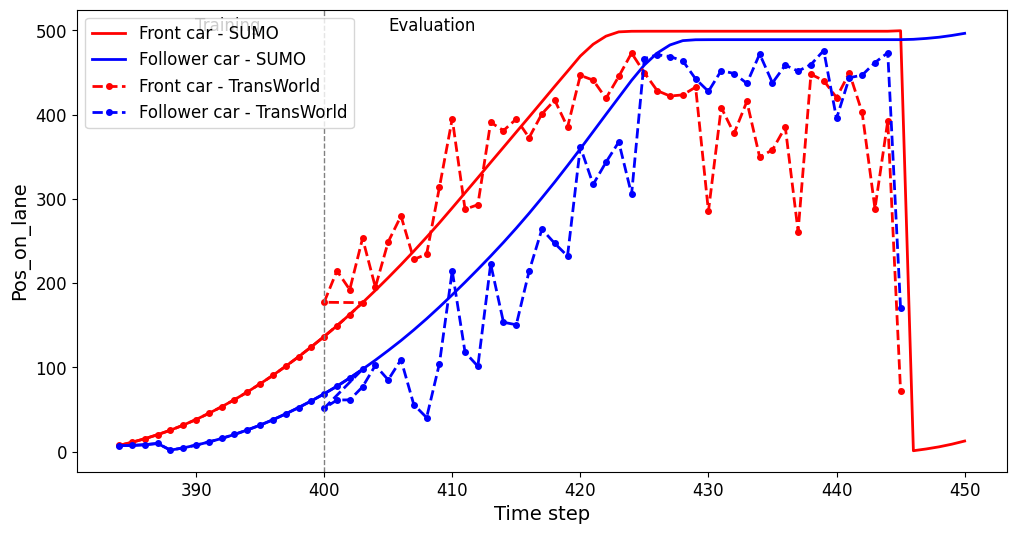

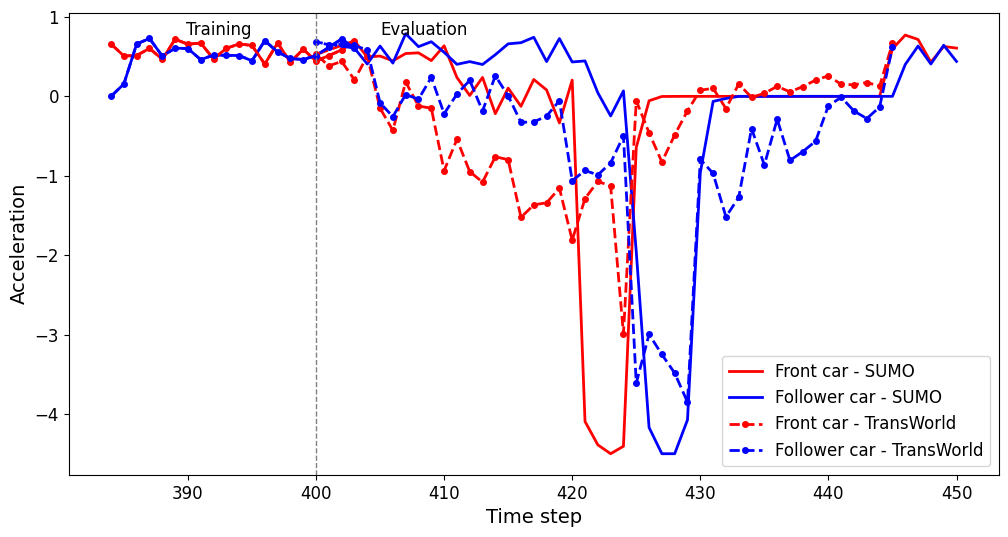

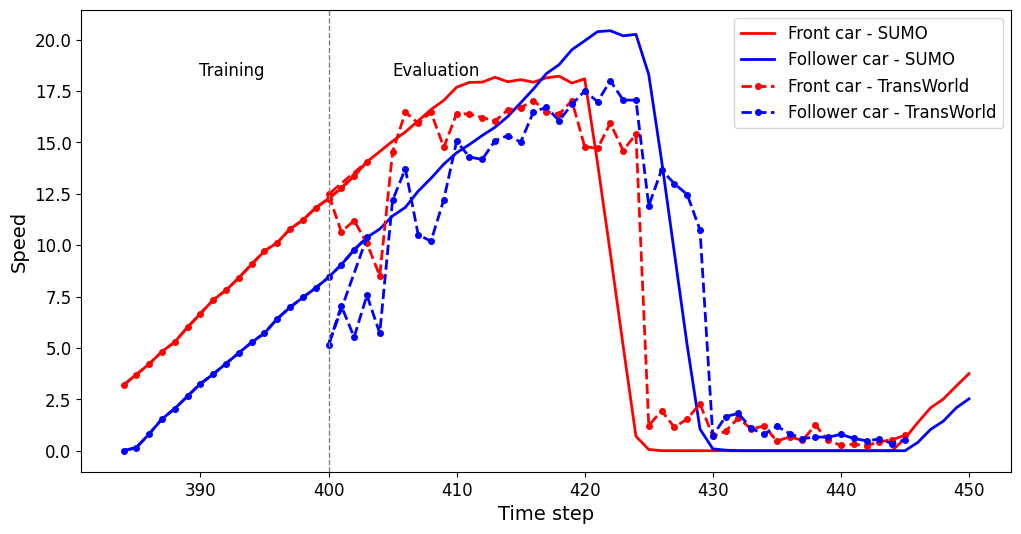

In [36]:
front_veh_id, behind_veh_id  = 72, 73

CF_plot(real_struc,real_feat,sim_feat,front_veh_id,behind_veh_id,'pos_on_lane',1)
CF_plot(real_struc,real_feat,sim_feat,front_veh_id,behind_veh_id,"acceleration",1)
CF_plot(real_struc,real_feat,sim_feat,front_veh_id,behind_veh_id,"speed",1)
